In [485]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE

In [486]:
import warnings
warnings.filterwarnings('ignore')

In [487]:
DATA_ROOT = Path('./data/')
MODELS_PATH = Path('./models/')

TRAIN_DATASET_PATH = DATA_ROOT / 'train.csv'
VALID_DATASET_PATH = DATA_ROOT / 'test.csv'  # Проверочный набор данных

MY_RANDOM_STATE = 42
BALANCE_METHOD = 'under'

In [488]:
TARGET_NAME = 'Credit Default'

NUM_FEATURE_NAMES = [
    'Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 
    'Number of Credit Problems', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 
    'Monthly Debt', 'Credit Score', 'Years in current job'
]

CAT_FEATURE_NAMES = [
    'Home Ownership_Have Mortgage',
    'Home Ownership_Home Mortgage',
    'Home Ownership_Own Home',
    'Home Ownership_Rent',
    'Purpose_business loan',
    'Purpose_buy a car',
    'Purpose_buy house',
    'Purpose_debt consolidation',
    'Purpose_educational expenses',
    'Purpose_home improvements',
    'Purpose_major purchase',
    'Purpose_medical bills',
    'Purpose_moving',
    'Purpose_other',
    'Purpose_renewable energy',
    'Purpose_small business',
    'Purpose_take a trip',
    'Purpose_vacation',
    'Purpose_wedding',
    'Term_Long Term',
    'Term_Short Term' 
]

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES
if MODEL_PARAMS[TRY_NUM].get('top_feature_name'):
    SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + list(set(CAT_FEATURE_NAMES).\
                                  intersection(set(MODEL_PARAMS[TRY_NUM].get('top_feature_name')))) 
else:
    SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES

**Основные классы, функции**

In [489]:
class DataPreprocessing():
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        
        self.medians = None
        self.years_in_current_job_to_numbers = {
            '< 1 year': 1,  
            '2 years': 2, 
            '3 years': 3, 
            '4 years': 4, 
            '5 years': 5, 
            '6 years': 6, 
            '7 years': 7, 
            '8 years': 8, 
            '9 years': 9, 
            '10+ years': 10
        }
   
    def pre_transform(self, df):
        """Пред.трансформация/очистка данных"""
        
         # Years in current job - количество лет на текущем месте работы
        
        df['Years in current job'] = df['Years in current job'].map(self.years_in_current_job_to_numbers)
        
         # Months since last delinquent - количество месяцев с последней просрочки платежа
        
        df = df.drop('Months since last delinquent', axis=1)

        # Tax Liens - налоговые обременения
        # Большая часть значений равна 0.
         
        df = df.drop('Tax Liens', axis=1)
        
        return df
        
    def fit(self, df):
        """Сохранение статистик"""

        self.medians = df.median()

        return df
    
    def transform(self, df):
        """Трансформация данных"""
        
        # Bankruptcies - банкротства
        
        train_df.loc[train_df['Bankruptcies'] > 1, 'Bankruptcies'] = 1
        
        # Уменьшение объема памяти, занимаемого датафреймом
        
        df = self.reduce_mem_usage(df)
        
        # Заполнение "сильных" свойств пустыми значениями, чтобы не улучшать плохие записи за счет других.
        
        values = {
            'Years of Credit History': 0,
            'Credit Score': 0,
            'Years in current job': 1,
            'Purpose': 'other',
        }
        df.fillna(value=values, inplace=True)
       
        # Контрольное заполнение всех прочих неуказанных данных медианными значениями
        
        df.fillna(self.medians[NUM_FEATURE_NAMES], inplace=True)
        
        return df
    
    def reduce_mem_usage(self, df):
        """ iterate through all the columns of a dataframe and modify the data type
            to reduce memory usage.        
        """
        start_mem = df.memory_usage().sum() / 1024**2
        print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

        for col in df.columns:
            col_type = df[col].dtype

            if col_type != object:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
            else:
                df[col] = df[col].astype('category')

        end_mem = df.memory_usage().sum() / 1024**2
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

        return df     

In [490]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        pass

      
    def fit(self, df):
        return df
        
    def transform(self, df):
        
        # Maximum Open Credit - наибольший открытый кредит

        bins = [0, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000, 99999999999]
        df['Maximum Open Credit'] = pd.cut(df['Maximum Open Credit'], bins=bins, labels=False)
        df['Maximum Open Credit'].fillna(-1, inplace=True)
        
        # Current Loan Amount - текущая сумма кредита
        
        bins = [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000,
        500000, 550000, 600000, 650000, 700000, 750000, 800000, 850000, 900000, 
        950000, 1000000, 99999999999]

        df['Current Loan Amount'] = pd.cut(df['Current Loan Amount'], bins=bins, labels=False)
        df['Current Loan Amount'].fillna(0, inplace=True) 
        
        # Dummy 
        
        DUMMY_NAMES = []
        
        # Home Ownership - домовладение
        
        DUMMY_NAMES.append('Home Ownership')
        
        # Purpose - цель кредита
        
        DUMMY_NAMES.append('Purpose')
        
        # Term - срок кредита
        
        DUMMY_NAMES.append('Term')
        
        # Dummy
        
        df = pd.get_dummies(df, columns=DUMMY_NAMES)
        
        # Выравниваем кол-во колонок dummy (если в тесте будут отсутствовать некоторые значения свойств)
        
        df_columns = list(df)
        for col in CAT_FEATURE_NAMES:
            if col not in df_columns:
                df[col] = 0
        
        return df    

In [491]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print('TRAIN ------------------------------------\n' + classification_report(y_train, y_train_pred))
    print('TEST  ------------------------------------\n' + classification_report(y_test, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test, y_test_pred))    

In [492]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(target_name, axis=1), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(df.drop(target_name, axis=1), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [493]:
def display_important_features(df, model, col_name_importance='Importance', show_table=False):
    """Отображение гистограммы с важностью свойств обученной модели"""
    
    feats = {}
    for feature, importance in zip(df.columns, model.feature_importances_):
        feats[feature] = importance

    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: col_name_importance})
    importances = importances.sort_values(by=col_name_importance, ascending=False)
    importances = importances.reset_index()
    importances = importances.rename(columns={'index': 'Features'})
    
    sns.set(font_scale = 5)
    sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
    
    fig, ax = plt.subplots()
    fig.set_size_inches(30,15)
    
    sns.barplot(x=importances[col_name_importance], y=importances['Features'], data=importances, color='skyblue')
    
    plt.xlabel('Importance', fontsize=25, weight = 'bold')
    plt.ylabel('Features', fontsize=25, weight = 'bold')
    plt.title('Feature Importance', fontsize=25, weight = 'bold')
    
    display(plt.show())
    if show_table:
        display(importances)

In [494]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [495]:
def get_top_importances(feature_names, feature_importances, get_top):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
    return feature_importances['feature'][:get_top].tolist()

In [496]:
def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred,3))
    return 'f1_err', err

**Начало обучения**

In [497]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, delimiter=',')

In [498]:
preprocessor = DataPreprocessing()
features_gen = FeatureGenetator()

train_df = train_df.\
    pipe(preprocessor.pre_transform).\
    pipe(preprocessor.fit).\
    pipe(preprocessor.transform).\
    pipe(features_gen.fit).\
    pipe(features_gen.transform)

Memory usage of dataframe is 0.86 MB
Memory usage after optimization is: 0.34 MB
Decreased by 59.9%


In [499]:
train_df.shape

(7500, 33)

In [500]:
train_df.isnull().values.any()

False

In [501]:
train_df.head(10)

,Annual Income,Years in current job,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,...,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
0,482087.0,1.0,11.0,26.299999,6.0,1.0,1.0,20,47386.0,7914.0,...,0,0,0,0,0,0,0,0,0,1
1,1025487.0,10.0,15.0,15.300000,10.0,0.0,0.0,5,394972.0,18373.0,...,0,0,0,0,0,0,0,0,1,0
2,751412.0,8.0,11.0,35.000000,10.0,0.0,0.0,20,308389.0,13651.0,...,0,0,0,0,0,0,0,0,0,1
3,805068.0,6.0,8.0,22.500000,1.0,1.0,1.0,2,95855.0,11338.0,...,0,0,0,0,0,0,0,0,0,1
4,776264.0,8.0,13.0,13.600000,3.0,1.0,0.0,2,93309.0,7180.0,...,0,0,0,0,0,0,0,0,0,1
5,1168386.0,7.0,12.0,14.600000,3.0,0.0,0.0,6,165680.0,18692.0,...,0,0,1,0,0,0,0,0,1,0
6,1511108.0,10.0,9.0,20.299999,3.0,0.0,0.0,20,51623.0,2317.0,...,0,0,0,0,0,0,0,0,0,1
7,1040060.0,10.0,13.0,12.000000,3.0,0.0,0.0,5,89015.0,19761.0,...,0,0,1,0,0,0,0,0,0,1
8,1168386.0,5.0,17.0,15.700000,-1.0,1.0,1.0,2,19.0,17.0,...,0,0,0,0,0,0,0,0,0,1
9,1168386.0,1.0,10.0,24.600000,5.0,0.0,0.0,11,205333.0,17613.0,...,0,0,0,0,0,0,0,0,1,0


**Анализ числовых свойств**

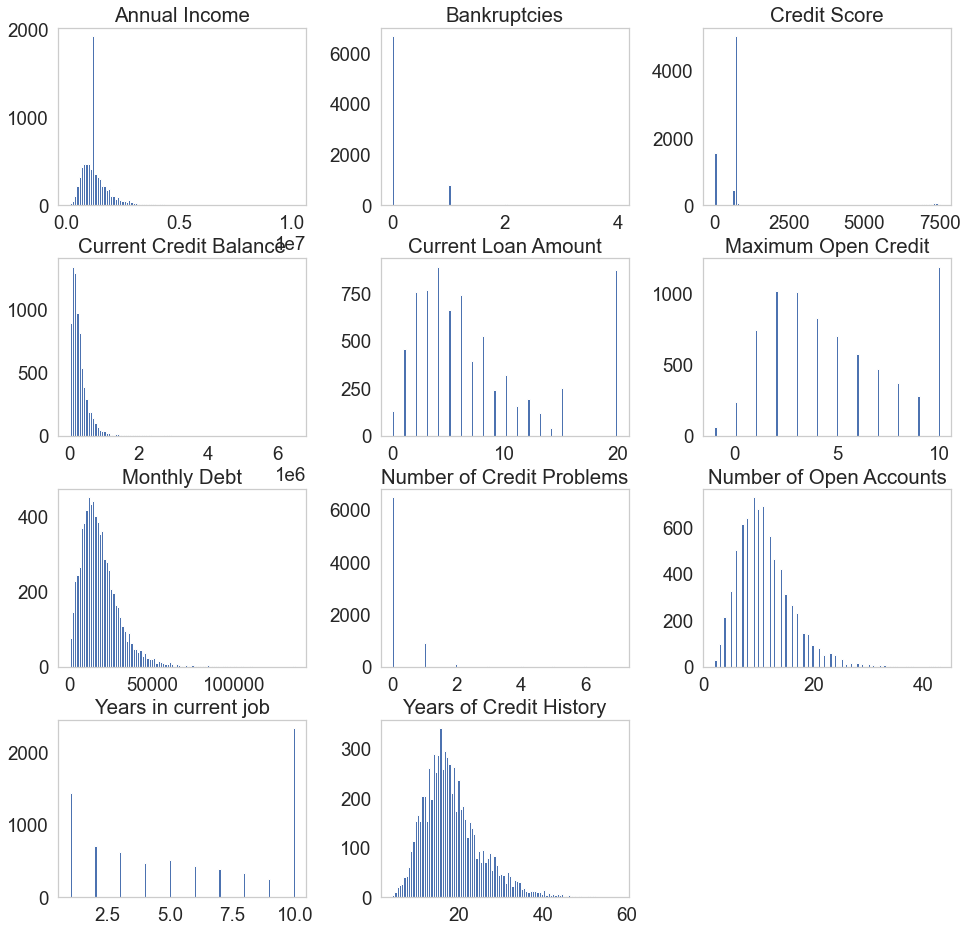

In [502]:
train_df[NUM_FEATURE_NAMES].hist(figsize=(16,16), bins=100, grid=False);

**Разбиение на train и test**

In [503]:
X = train_df[SELECTED_FEATURE_NAMES]
y = train_df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=MY_RANDOM_STATE,
                                                    stratify=y)

In [504]:
X_train.shape

(5250, 32)

In [505]:
X_test.shape

(2250, 32)

**Балансировка по целевой переменной**

In [506]:
# Балансировку только на train часть из train.csv, а test часть оставить с дисбалансом классов, 
# чтобы более объективно понимать, как модель себя будет вести на данных с дисбалансом классов.

balanced_df = pd.concat([X_train, y_train], axis=1)

balanced_df.shape

(5250, 33)

In [507]:
balanced_df[TARGET_NAME].value_counts(normalize=True)

0    0.718286
1    0.281714
Name: Credit Default, dtype: float64

In [508]:
balanced_df = balance_df_by_target(balanced_df, TARGET_NAME, method=BALANCE_METHOD)

In [509]:
balanced_df.shape

(2958, 33)

In [510]:
balanced_df[TARGET_NAME].value_counts(normalize=True)

1    0.5
0    0.5
Name: Credit Default, dtype: float64

In [511]:
X_train = balanced_df[SELECTED_FEATURE_NAMES]
y_train = balanced_df[TARGET_NAME]

target_disbalance_koef = y_train.value_counts(normalize=True)[0] / y_train.value_counts(normalize=True)[1]
print(f'koef={target_disbalance_koef}')

koef=1.0


**Кросс-валидация**

In [512]:
%%time

def CrossVal():
    model_xgb = xgb.XGBClassifier(random_state=MY_RANDOM_STATE, 
                                  objective='binary:logistic', 
                                  eval_metric='logloss',
                                  booster='gbtree')
    model_xgb.fit(X_train, y_train, eval_metric=f1_eval)

    params = {
        'max_depth': [5], 
        'min_child_weight': [1], 
        'reg_lambda': [1500],
        'learning_rate': [0.01, 0.05, 0.1, 0.5, 0, 1, 5, 10,20,30,40]
    }

    cv = StratifiedKFold(n_splits=3, random_state=MY_RANDOM_STATE, shuffle=True)

    grid_search = GridSearchCV(param_grid=params, estimator=model_xgb, cv=cv, verbose=0, scoring='f1')
    grid_search.fit(X_train, y_train)

    display(grid_search.best_params_, grid_search.best_score_)
    
# CrossVal()

Wall time: 0 ns


**XGBoost (финальная модель)**

In [513]:
%%time

TRY_NUM = 2

MODEL_PARAMS = [
    # Try 0
    {'xgb_params': {
         'max_depth': 15, 
         'min_child_weight': 1,
         'n_estimators': 90, 
         'reg_alpha': 0.1,
         'reg_lambda': 10,
        }
    },
    # Try 1 (over)
    {'xgb_params': {
         'max_depth': 9, 
         'min_child_weight': 1,
         'reg_alpha': 0.1,
         'reg_lambda': 1500,
        }
    },
    # Try 2 (under)
    {'xgb_params': {
         'max_depth': 5, 
         'min_child_weight': 1,
         'reg_lambda': 1500,
       }
    },

]

model_xgb = xgb.XGBClassifier(**MODEL_PARAMS[TRY_NUM].get('xgb_params'),
                              random_state=MY_RANDOM_STATE, 
#                               objective='binary:logistic', 
#                               eval_metric='logloss',
#                               booster='gbtree'
                             )

# model_xgb.fit(X_train, y_train)
model_xgb.fit(X_train, y_train, eval_metric=f1_eval)

evaluate_preds(model_xgb, X_train, X_test, y_train, y_test)

[09:11:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN ------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.71      0.72      1479
           1       0.72      0.72      0.72      1479

    accuracy                           0.72      2958
   macro avg       0.72      0.72      0.72      2958
weighted avg       0.72      0.72      0.72      2958

TEST  ------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.67      0.75      1616
           1       0.45      0.71      0.55       634

    accuracy                           0.68      2250
   macro avg       0.65      0.69      0.65      2250
weigh

In [514]:
model_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1500, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

**Сохранение финальной модели**

In [515]:
with open(MODELS_PATH / f'model_v2_{TRY_NUM}.pkl', 'wb') as file:
    pickle.dump(model_xgb, file)

**Важность признаков**

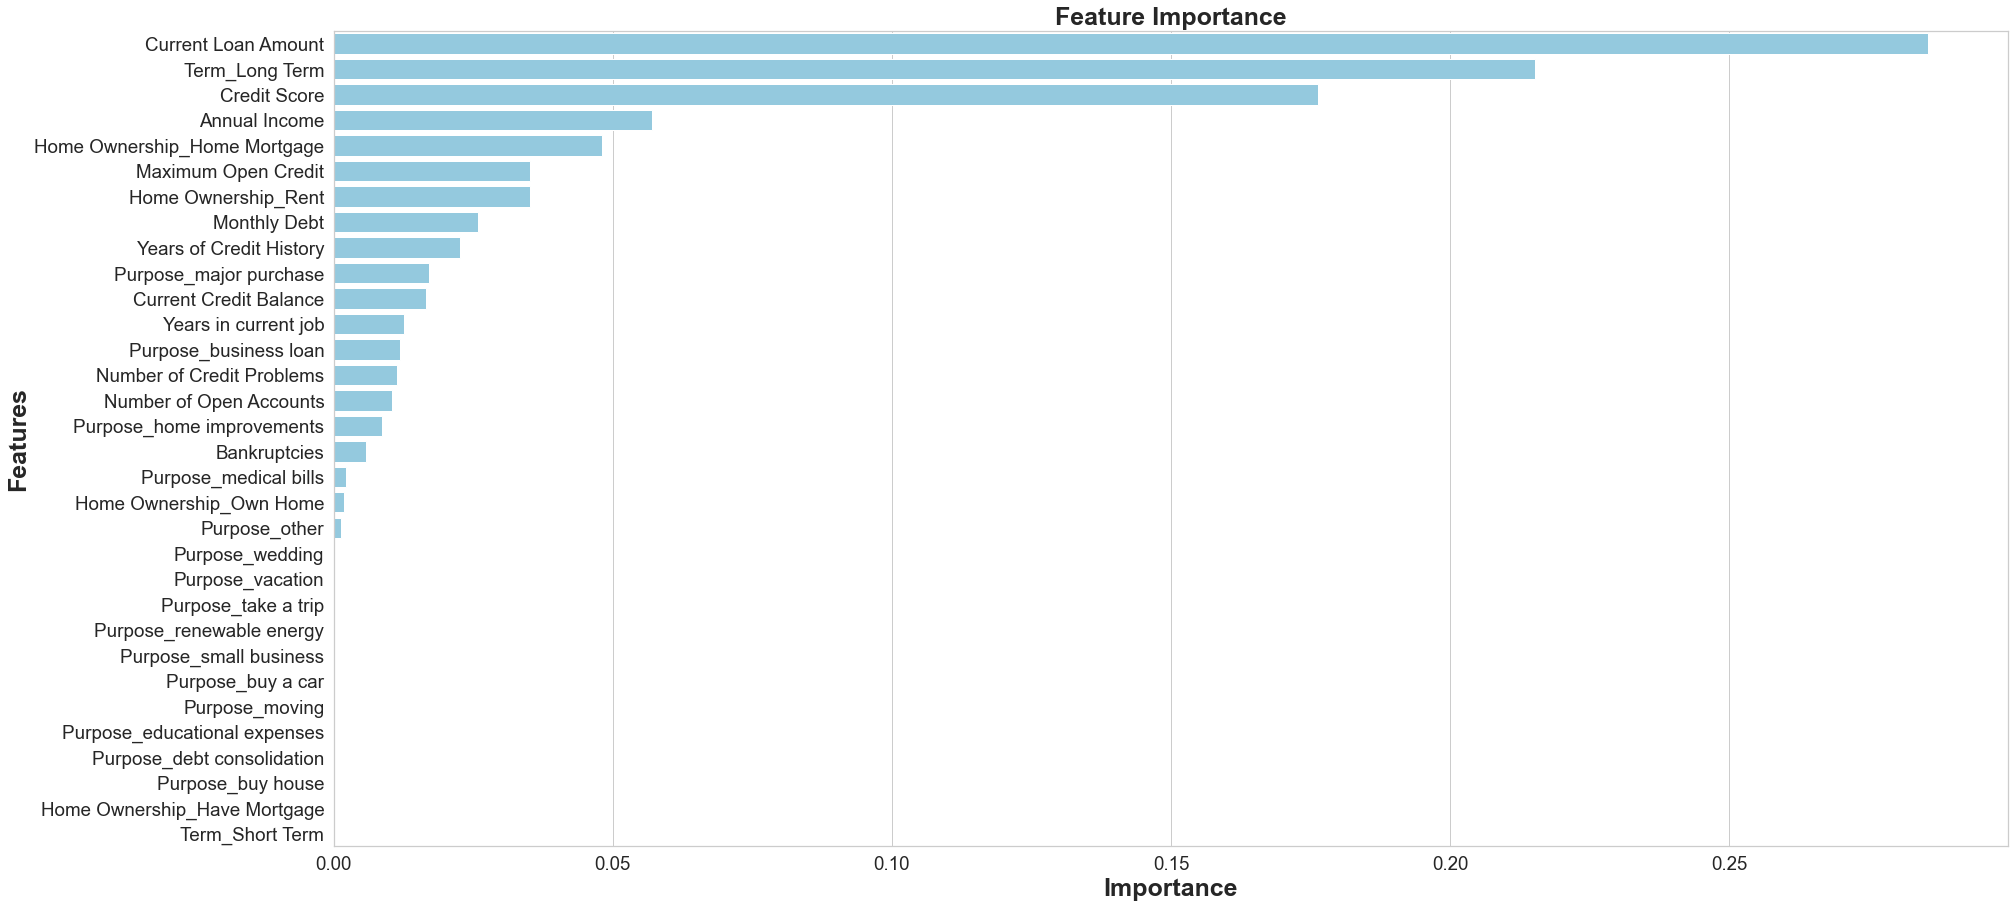

None

In [516]:
display_important_features(X_train, model_xgb)

In [517]:
display(get_top_importances(X_train.columns, model_xgb.feature_importances_, 10))

['Current Loan Amount',
 'Term_Long Term',
 'Credit Score',
 'Annual Income',
 'Home Ownership_Home Mortgage',
 'Maximum Open Credit',
 'Home Ownership_Rent',
 'Monthly Debt',
 'Years of Credit History',
 'Purpose_major purchase']

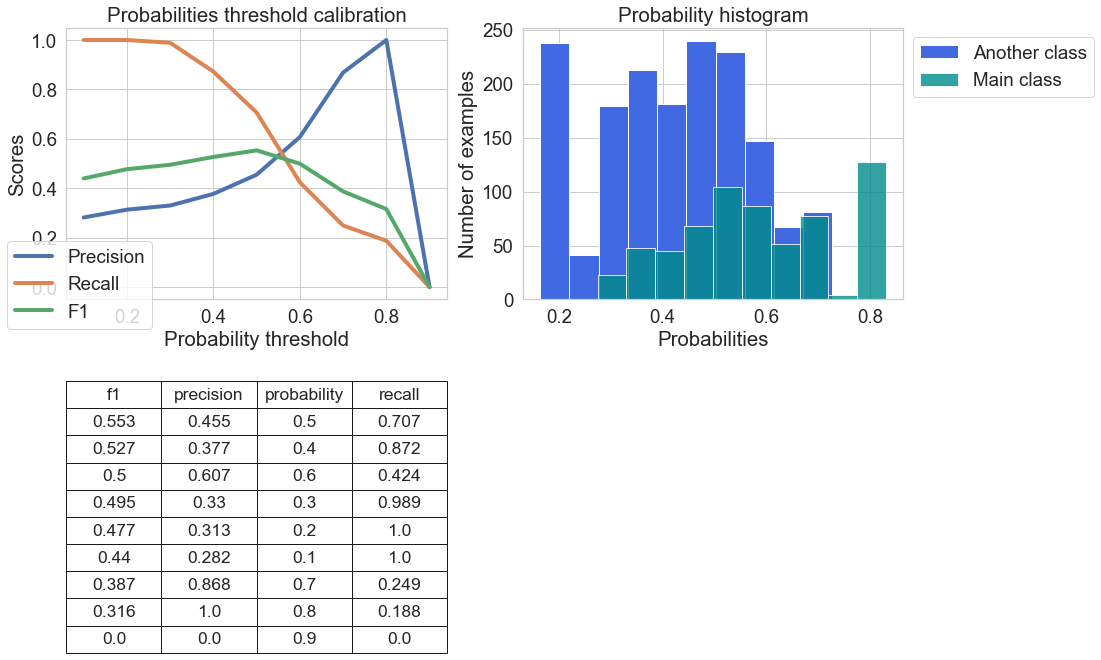

In [518]:
# Выбор порога вероятности для определения класса

y_test_pred_probs = model_xgb.predict_proba(X_test)
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

**Прогноз на валидационном наборе данных**

In [519]:
valid_df = pd.read_csv(VALID_DATASET_PATH, delimiter=',')
valid_df.shape

(2500, 16)

In [520]:
# valid_df.describe()

In [521]:
valid_df = valid_df.pipe(preprocessor.pre_transform).\
    pipe(preprocessor.transform).\
    pipe(features_gen.transform)

Memory usage of dataframe is 0.27 MB
Memory usage after optimization is: 0.11 MB
Decreased by 57.6%


In [522]:
valid_df = valid_df[SELECTED_FEATURE_NAMES]
valid_df.shape

(2500, 32)

In [523]:
predictions = model_xgb.predict(valid_df)
predictions

array([1, 1, 1, ..., 1, 0, 1], dtype=int8)

In [524]:
len(predictions)

2500

In [525]:
# Запись результатов предсказания в файл

submit = pd.read_csv(DATA_ROOT / 'sample_submission.csv')
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [526]:
submit['Credit Default'] = predictions
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,0
4,4,0


In [527]:
submit.to_csv(DATA_ROOT / f'model_v2_submit_{TRY_NUM}.csv', index=False)